## Visualize the predicted result of White Blood Cells classification

### Before using this notebook

- Install [Pytorch](https://pytorch.org/get-started/locally/)
- Install dependencies
```barsh
pip install numpy
pip install matlplotlib
pip install scikit-learn
```

- Create an destination folder to save the predicted result
- Edit `dataset_path`, `weight_path` and `save_path` to correct path

### Running

Follow above directions to setup and run this cell to check

In [1]:
import os
from numpy.random import choice
import torch
import torch.nn as nn
from torchvision import models, transforms
import matplotlib.pyplot as plt
from PIL import Image
import glob
import shutil
from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report

In [2]:
dataset_path = "../final_labels/Mitalab"
weight_path = "../src/classifier/weights/alexnet__07-03-2021_11-28-16__Pretrained.pt"
model_name = "alexnet"
cell_group = "wbc" # or "rbc" for red blood cells
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def initialize_model(model_name, num_classes, weight_path):
    model_ft = None

    if model_name == "resnet":
        """
        Resnet50
        """
        model_ft = models.resnet50()
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)

    elif model_name == "alexnet":
        """
        Alexnet
        """
        model_ft = models.alexnet()
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)

    elif model_name == "vgg":
        """
        VGG11_bn
        """
        model_ft = models.vgg11_bn()
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)

    elif model_name == "squeezenet":
        """
        Squeezenet
        """
        model_ft = models.squeezenet1_0()
        model_ft.classifier[1] = nn.Conv2d(
            512, num_classes, kernel_size=(1, 1), stride=(1, 1))
        model_ft.num_classes = num_classes

    elif model_name == "densenet":
        """
        Densenet
        """
        model_ft = models.densenet121()
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        
    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3()
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)

    else:
        print("Invalid model name, exiting...")
        exit()

    model_ft.load_state_dict(torch.load(weight_path, map_location=device))
    model_ft.eval()
    return model_ft

In [4]:
#Modify paths
actual = []
input_size = 299 if (model_name == "inception") else 224

def predict(model, dataset_path, class_names):
    loader = transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    actual, res = [], []
    filenames = glob.glob(os.path.join(dataset_path, '*/*'))
    for file in filenames:
        actual.append(os.path.basename(os.path.dirname(file)))
        image = Image.open(file).convert('RGB')
        image_tensor = loader(image).float()
        inp = image_tensor.unsqueeze(0)

        inp = inp.to(device)
        model = model.to(device)

        out = model(inp)
        confs = nn.functional.softmax(out[0], dim=0)
        _, pred = torch.max(out, 1)
        res.append([file, class_names[pred[0]], confs[pred[0]].item()])
    return res, actual

In [5]:
cls_num = {
    "rbc": 3,
    "wbc": 5
}

model = initialize_model(model_name, cls_num[cell_group], weight_path)

cls_names = {
    "wbc": ['basophil', 'eosinophil', 'lymphocyte', 'monocyte', 'neutrophil'],
    "rbc": ['circular', 'elongated', 'other']
}
res, actual = predict(model, dataset_path, cls_names[cell_group])

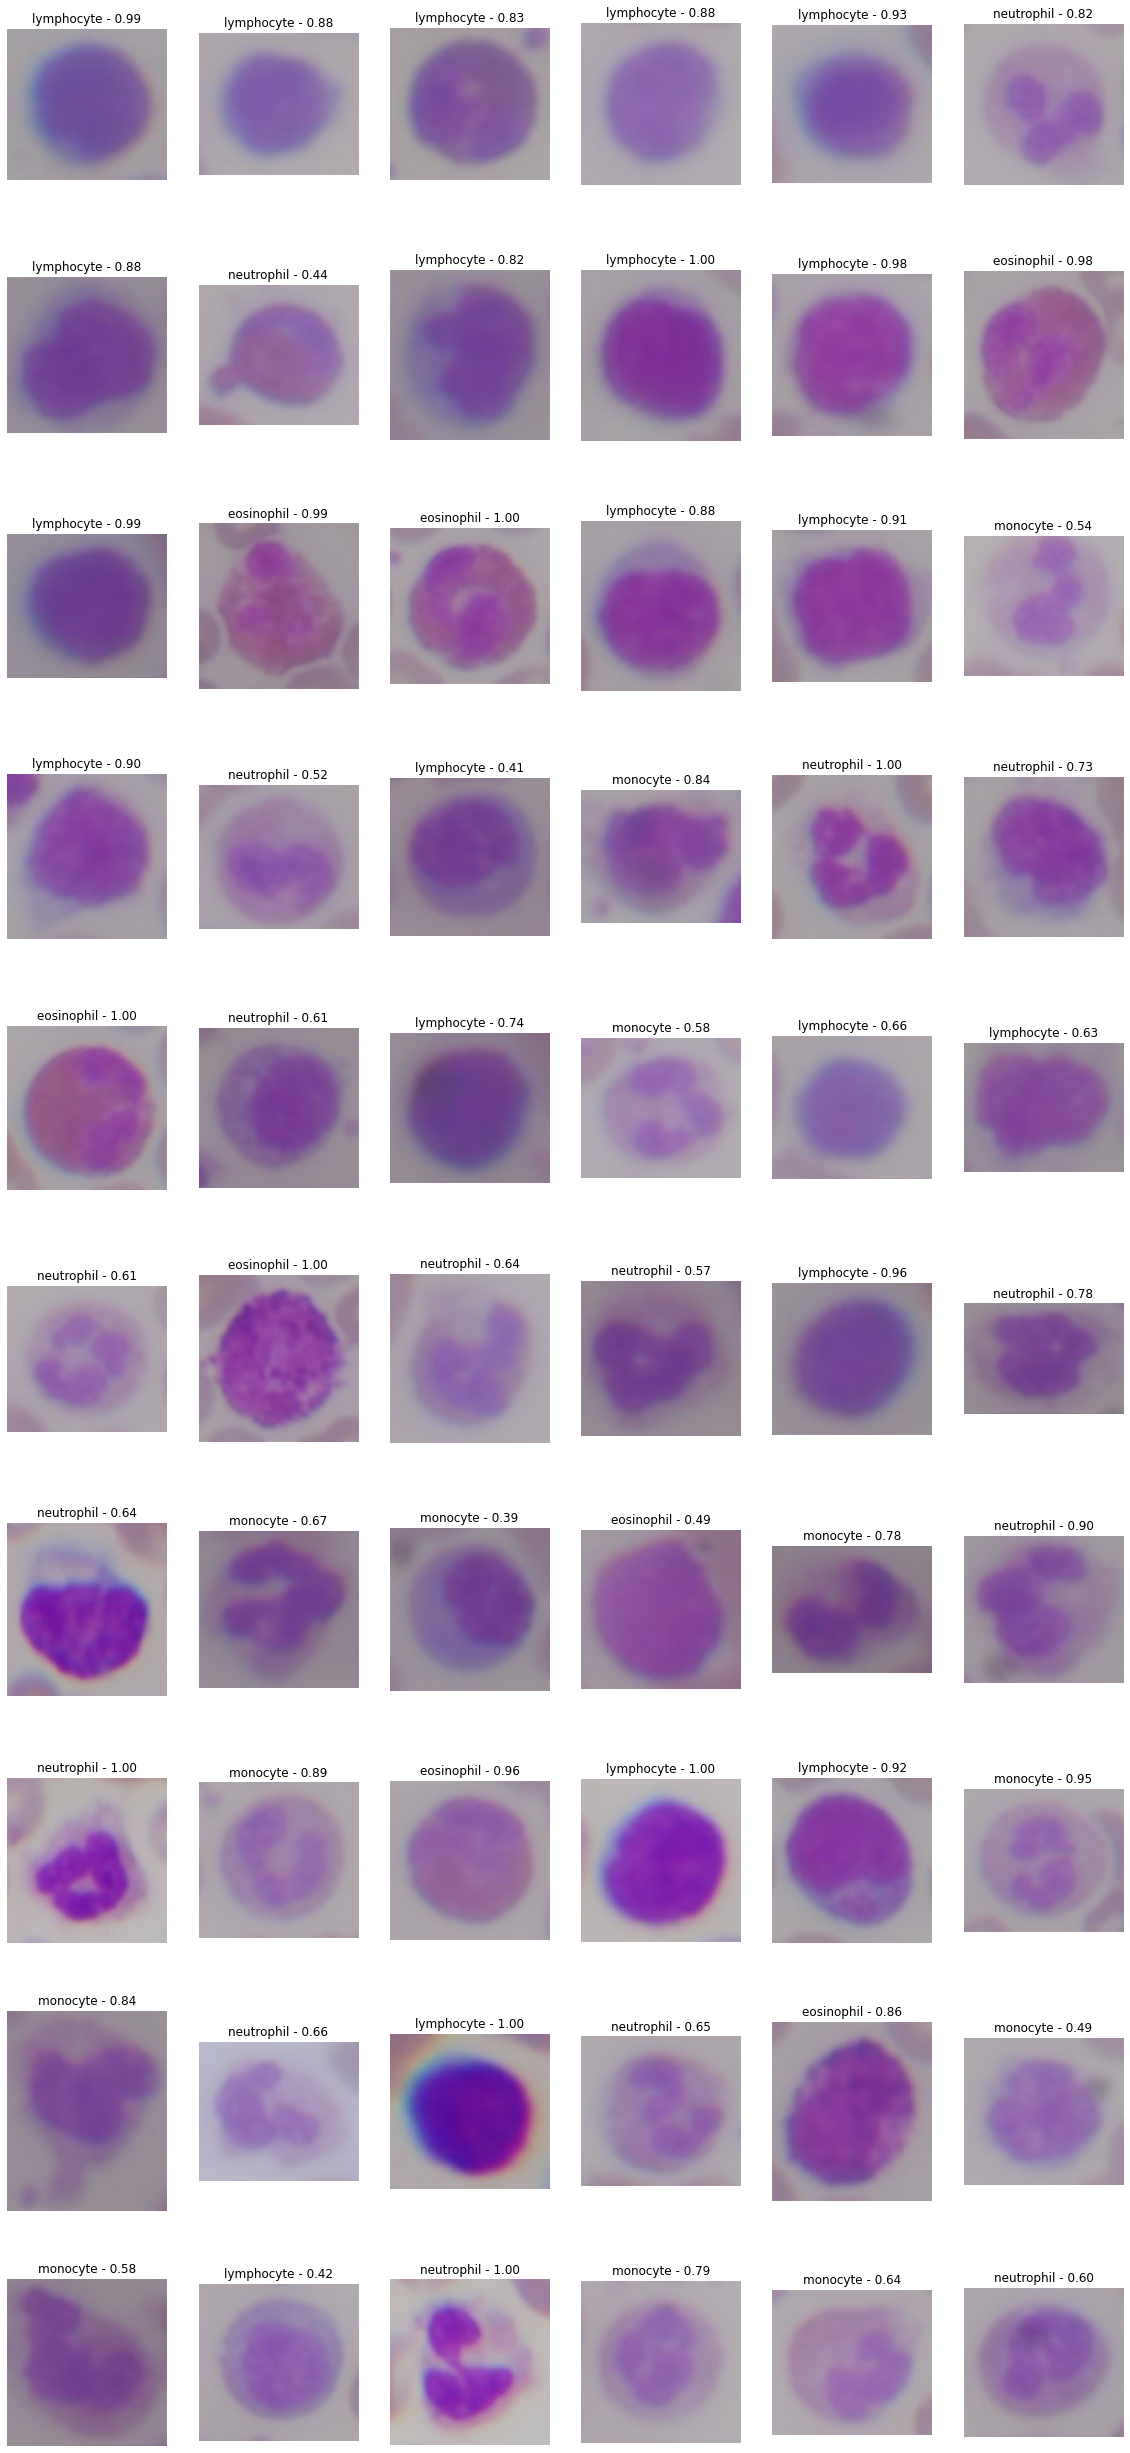

In [6]:
def plot_predicted_single_cell(res, max_row, columns):
    fig = plt.figure()
    num_of_sample = min(max_row*col, len(res))
    rows = int(num_of_sample/columns) + 1
    for i, cell_idx in enumerate(choice(len(res), num_of_sample, replace=False)):
        cell = res[cell_idx]
        fig.add_subplot(rows, columns, i+1)
        plt.gcf().set_size_inches(20, 50)
        plt.title(f"{cell[1]} - {cell[2]:.2f}")
        plt.axis('off')
        plt.imshow(Image.open(cell[0]))
    plt.show()
    
max_row = 10
col = 6
plot_predicted_single_cell(res, max_row, col)

In [7]:
pred = []

for cell in res:
    pred.append(cell[1])

In [8]:
confusion_matrix(pred, actual, labels=["basophil", "eosinophil", "lymphocyte", "monocyte", "neutrophil"])

array([[ 0,  0,  0,  0,  0],
       [ 3, 15,  0,  0,  0],
       [ 1,  2, 36,  4,  0],
       [ 0,  0,  3,  4, 21],
       [ 0,  1,  3,  3, 35]], dtype=int64)

In [9]:
print(classification_report(pred, actual, digits=5))

              precision    recall  f1-score   support

    basophil    0.00000   0.00000   0.00000         0
  eosinophil    0.83333   0.83333   0.83333        18
  lymphocyte    0.85714   0.83721   0.84706        43
    monocyte    0.36364   0.14286   0.20513        28
  neutrophil    0.62500   0.83333   0.71429        42

    accuracy                        0.68702       131
   macro avg    0.53582   0.52935   0.51996       131
weighted avg    0.67396   0.68702   0.66540       131



d:\program\anaconda3\envs\env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
